# Solve 1D instationary heat equation

Arbitrary number of layers
Work in progress
For demonstration purpose and coding exercise, very inefficient for the following reasons:
- Very inefficient time integration method: explicit time integration only efficient for large 2D,3D problems using lobatto integration (not implemented yet)
- Numerical limitations in python, can probably be written a lot faster...

Layer  0 :  Name:  layer1   Density:  10   c:  2.5   k:  0.5   d:  0.1
Layer  1 :  Name:  layer2   Density:  40   c:  0.25   k:  2.0   d:  0.05
Layer  2 :  Name:  layer3   Density:  20   c:  4.5   k:  0.1   d:  0.2


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1989.84/s]


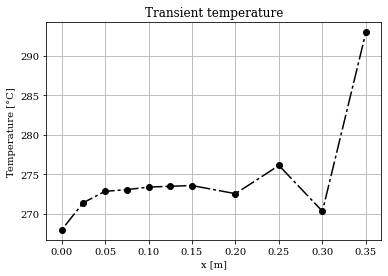

T at x=0: 267.98676 T at x= 0.35 292.98447
Layer  0 :  Name:  layer1   Density:  10   c:  2.5   k:  0.5   d:  0.1
Layer  1 :  Name:  layer2   Density:  40   c:  0.25   k:  2.0   d:  0.05
Layer  2 :  Name:  layer3   Density:  20   c:  4.5   k:  0.1   d:  0.2


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 2029.07/s]


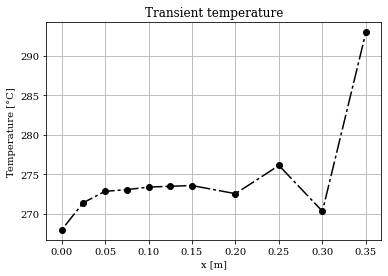

T at x=0: 267.98676 T at x= 0.35 292.98447


In [201]:
import numpy as np
import copy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from tqdm import tqdm #Fortschrittsbalken
from initinstat import *

intnodes,intweights = intnodes("gauss") # lobatto integration is work in progress



class Layer:
      
    def __init__(self, name = "Standard", roh = 2500, cspec = 1000, heatcond = 2.5, width = 0.1, nr_of_elements = 2):
        # roh: Dichte // cspec: Wärmespeicherkapazität // heatcond: Wärmeleitfähigkeit // width: Dicke
        self.name = name
        self.roh = roh
        self.cspec = cspec
        self.heatcond = heatcond
        self.width = width
        self.nr_of_elements = nr_of_elements
        self.fe_length = self.width/self.nr_of_elements
        self.elesteifmat = self.calc_elesteifmat(self.fe_length,self.heatcond)
        self.elemassmat = self.calc_elemassenmat(self.fe_length,self.roh,self.cspec)
        self.rodsteifmat, self.rodmassmat = self.calc_matrix(self.nr_of_elements,self.elesteifmat,self.elemassmat)
    
    def testfun(self):
        return 999.666
    
    def calc_elesteifmat(self, width, heatcond = 1):
        elesteifmat = np.zeros((3,3),dtype=np.double)

        for j in range(0,3):
            val = [[1/width*philequdistgrad(i+1,intnodes[j])*philequdistgrad(ii+1,intnodes[j])*intweights[j] for ii in range(0,3)] for i in range(0,3)]
            elesteifmat = elesteifmat + val
        return heatcond*elesteifmat

    def calc_elemassenmat(self,width,roh = 1, cspec = 1):
        elemassenmat = np.zeros((3,3),dtype=np.double)
        for j in range(0,3):
            val = [[width*philequdist(i+1,intnodes[j])*philequdist(ii+1,intnodes[j])*intweights[j] for ii in range(0,3)] for i in range(0,3)]
            elemassenmat = elemassenmat + val
        return roh*cspec*elemassenmat
    
    def calc_matrix(self,nr_of_elements, elesteifmat, elemassmat):
        matrix_size = nr_of_elements*2+1

        syssteifmatrix = np.zeros((matrix_size,matrix_size),dtype=np.double)
        insert_pos = np.array([range(0,matrix_size,2)[i:i+2] for i in range(nr_of_elements)])
        for i in insert_pos:
            syssteifmatrix[i[0]:i[1]+1,i[0]:i[1]+1] = elesteifmat + syssteifmatrix[i[0]:i[1]+1,i[0]:i[1]+1]

        sysmassmatrix = np.zeros((matrix_size,matrix_size),dtype=np.double)
        insert_pos = np.array([range(0,matrix_size,2)[i:i+2] for i in range(nr_of_elements)])
        for i in insert_pos:
            sysmassmatrix[i[0]:i[1]+1,i[0]:i[1]+1] = elemassmat + sysmassmatrix[i[0]:i[1]+1,i[0]:i[1]+1]   

        return syssteifmatrix,sysmassmatrix
    

    
class AllLayers:
    
    def __init__(self):
        self.list = [] 
        self.lenlist = len(self.list)
        self.nr_layers = 0
    
    def starttest(self): # Nur zum testen
        self.list.append(0)
        self.nr_layers += 1
        self.list[0] =  Layer(name = "layer1",roh = 10,cspec = 2.5,heatcond = 0.5,width = 0.1,nr_of_elements = 2)
        
        self.list.append(0)
        self.nr_layers += 1
        self.list[1] =  Layer(name = "layer2",roh = 40,cspec = 0.25,heatcond = 2.0,width = 0.05,nr_of_elements = 1)
        
        self.list.append(0)
        self.nr_layers += 1
        self.list[2] =  Layer(name = "layer3",roh = 20,cspec = 4.5,heatcond = 0.1,width = 0.2,nr_of_elements = 2)
    
    def printlayers(self):
        for i in range(self.nr_layers):
            print("Layer ",i,":  Name: ",self.list[i].name,"  Density: ",self.list[i].roh,"  c: ",self.list[i].cspec,
                 "  k: ",self.list[i].heatcond, "  d: ",self.list[i].width)
    
    def assemble_matrices(self,vector_rod_matrices): # Vector von zu assemblierende Matrizen
        # 1) Ermittelt Größe der Gesamtmatrix, Beginnend bei Größe Matrix 1 (bzw im python sinn) 
        # und addierend die weiteren Größen je -1
        nr_of_matrices = len(vector_rod_matrices)
        size_of_sys_matrix = np.sum(np.array([len(vector_rod_matrices[0])] + [len(matrix)-1 for matrix in vector_rod_matrices[1:]]))
        # Allokalisierung gesamtmaxtrix
        sys_matrix = np.zeros((size_of_sys_matrix,size_of_sys_matrix),dtype=np.double)
        # Einfügen in Gesamtmatrix, beginnend mit erster Matrix
        pos_sys_matrix_start = 0
        pos_sys_matrix_end = len(vector_rod_matrices[0])

        for i,matrix in enumerate(vector_rod_matrices):
            if i == 0:
                sys_matrix[0:pos_sys_matrix_end,0:pos_sys_matrix_end] = sys_matrix[0:pos_sys_matrix_end,0:pos_sys_matrix_end] + \
                vector_rod_matrices[0]

            else:
                pos_sys_matrix_start += len(vector_rod_matrices[i-1])-1
                pos_sys_matrix_end += len(vector_rod_matrices[i])-1
                sys_matrix[pos_sys_matrix_start:pos_sys_matrix_end,pos_sys_matrix_start:pos_sys_matrix_end] = \
                sys_matrix[pos_sys_matrix_start:pos_sys_matrix_end,pos_sys_matrix_start:pos_sys_matrix_end] + matrix

        return sys_matrix
    
    def assemblesysmatrices(self):
        vector_rod_matrices_stiff = []
        vector_rod_matrices_mass = []
        
        for i in range(self.nr_layers):
            vector_rod_matrices_stiff.append(self.list[i].rodsteifmat)
            vector_rod_matrices_mass.append(self.list[i].rodmassmat)
       
        self.sys_stiff_matrix = assemble_matrices(vector_rod_matrices_stiff)
        self.sys_mass_matrix = assemble_matrices(vector_rod_matrices_mass)        
    
    def createloadvector(self,length): # Creates zero loadvector of length length
        self.loadvector = np.zeros(length,dtype=np.double)

    def allnodes(self,vector_lengthnodes): # Eingabe als Liste für jedes elememt(rod) [length, nr_of_nodes]
        allelements = np.array([])
        for i,element in enumerate(vector_lengthnodes):
            length = element[0]
            nr_of_nodes = element[1]
            if i == 0:
                x_a = 0
                x_e = length
            else:
                x_a += vector_lengthnodes[i-1][0]
                x_e += length
            element_nodes = np.arange(x_a,x_e+length/nr_of_nodes,length/(nr_of_nodes-1))
            if i == len(vector_lengthnodes)-1:
                allelements = np.append(allelements,element_nodes[0:])
            else:
                allelements = np.append(allelements,element_nodes[0:-1])           
        return allelements
        
    def calcnodesvector(self):
        self.vector_lengthnodes = []
        
        for i in range(self.nr_layers):
            self.vector_lengthnodes.append([self.list[i].width,self.list[i].nr_of_elements*2+1])
            
        self.nodesvector = self.allnodes(self.vector_lengthnodes)
        
    def setrbs(self):
        # BCs
        temp_l = 268
        h_l = 1/0.04
        temp_r = 293
        h_r = 1/0.25

        # ICs
        dt = 0.00005 
        ndt = 300
        init_temp = 273
        
        self.rbvector = [temp_l,h_l,temp_r,h_r,dt,ndt,init_temp]

class calctrans:
    
    def __init__(self, steifmat, massmat,rbvector):
        self.steifmat = steifmat
        self.massmat = massmat
        self.rbvector = rbvector # rbvector = [temp_l,h_l,temp_r,h_r,dt,ndt,init_temp]
    
    def implementrobin(self,matrix,loadvector,pos,gamma,g):
        matrix_c = copy.copy(matrix)
        loadvector_c = copy.copy(loadvector)
        matrix_c[pos,pos] = matrix_c[pos,pos]-gamma
        loadvector_c[pos] = loadvector_c[pos]-g
        return matrix_c,loadvector_c
    
    def trans(self):
        kmat = self.steifmat
        mmat = self.massmat 
        
        nr_of_nodes = len(self.massmat)
        
        temp_l = self.rbvector[0]
        h_l = self.rbvector[1]
        temp_r = self.rbvector[2]
        h_r = self.rbvector[3]
        
        dt = self.rbvector[4]
        ndt = self.rbvector[5]
        init_temp = self.rbvector[6]
        
        gamma_l = -h_l
        g_l = -temp_l*h_l
        gamma_r = -h_r
        g_r = -temp_r*h_r
        
        pos_l = 0
        pos_r = nr_of_nodes-1
        
        pmat = range(nr_of_nodes)
        pmat = np.array(pmat,dtype=np.double)
        pmat[:] = init_temp
        """Something is wrong with implementation of robin bcs..."""
        steifmat_full_rbs,loadvector = self.implementrobin(kmat,pmat,pos_l,gamma_l,g_l) 
        steifmat_full_rbs,loadvector = self.implementrobin(steifmat_full_rbs,pmat,pos_r,gamma_r,g_r)
        
        for ts in tqdm(range(ndt), total=ndt, unit=""):
            rsvekmat = (mmat-dt*steifmat_full_rbs)
            rsvek = np.dot(rsvekmat, pmat)
            mmath = copy.copy(mmat)

            massmat_full_rbs,loadvector_rbs = self.implementrobin(mmath,rsvek,pos_l,gamma_l,g_l) 
            massmat_full_rbs,loadvector_rbs = self.implementrobin(massmat_full_rbs,loadvector_rbs,pos_r,gamma_r,g_r) 

            loadvector_rbs = np.reshape(loadvector_rbs,(nr_of_nodes,1))
            loadvector_csc = csc_matrix(loadvector_rbs, dtype=np.float32)

            massmat_full_rbs = csc_matrix(massmat_full_rbs, dtype=np.float32)

            solution = spsolve(massmat_full_rbs, loadvector_csc)


            pmat = solution
        self.solution = solution
        
class output:
    
    def __init__(self,solution,nodevector):
        self.solution = solution
        self.nodevector = nodevector
    
    def graphicaloutput(self):
        x = self.nodevector 
        y = self.solution
        
        # set the font 
        font_globally = "serif" 
        plt.rcParams.update({'font.family':font_globally})
        
        # font size
        plt.rc('font', size=12) #controls default text size
        plt.rc('axes', titlesize=12) #fontsize of the title
        plt.rc('axes', labelsize=10) #fontsize of the x and y labels
        plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
        plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
        plt.rc('legend', fontsize=10) #fontsize of the legend
        
        fig, ax = plt.subplots()
        line,=ax.plot(x, y,"o",color="black") # "o" setzt marker
        
        ax.set(xlabel='x [m]', ylabel='Temperature [°C]',
        title='Transient temperature')
        ax.grid()
        line.set_dashes([2, 2, 10, 2])
        plt.show()
        
        print("T at x=0:",y[0],"T at x=",x[-1],y[-1])  
        
def main():
    start = AllLayers()
    start.starttest() 
    start.printlayers()
    start.assemblesysmatrices()
    start.calcnodesvector()
    start.setrbs()
    
    steifmat_sys = start.sys_stiff_matrix
    massmat_sys = start.sys_mass_matrix
    nodevector = start.nodesvector
    rbvector = start.rbvector
    
    startcalc = calctrans(steifmat_sys,massmat_sys,rbvector)
    startcalc.trans()
    solution = startcalc.solution
    
    graphics = output(solution,nodevector)
    graphics.graphicaloutput() 
    
main()

if __name__ == '__main__':
    main()